## Run the Self-Organizing Map
___

First, load the data

In [1]:
from astropy.io import fits
from astropy.table import Table

import numpy as np

In [23]:
#Load in data produced in primary_targeting_region.ipynb
cut_data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr100_lms6_12_03jul2024.fits'

with fits.open(cut_data_file) as cat:
    GAMA_vect_data = Table(cat[1].data)

GAMA_vect_data.add_column(GAMA_vect_data['r_mag_err'], index = 4, name = 'surf_bright_r_err')

In [52]:
#Select the needed data
input_data = GAMA_vect_data['r_mag', 'gr_color', 'surf_bright_r']
input_stds = GAMA_vect_data['r_mag_err', 'gr_color_err', 'surf_bright_r_err']

input_labels = GAMA_vect_data['r_mag', 'gr_color', 'surf_bright_r', 'log_stellar_mass', 'redshift']

tuple_labels = input_labels.as_array()
list_labels = [list(values) for values in tuple_labels]
input_labels = np.array(list_labels)

In [53]:
#Bin by redshift
redshift_thresh = 0.2
redshift_idx = input_labels[:, -1] < redshift_thresh
print(np.sum(redshift_idx))

input_data = input_data[redshift_idx]
input_stds = input_stds[redshift_idx]
input_labels = input_labels[redshift_idx]

print(f'Input data len: {len(input_data)}')

14273
Input data len: 14273


___

Initialize the SOM

In [55]:
from mpdg_som import SelfOrganizingMap

In [56]:
#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [28, 28] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.93 #used to adjust the learning rate function
kernel_spread = 5.01 #used to adjust the neighborhood function
maximum_steps = 20 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.075 #used to stop the SOM if termination = 'error thresh'

In [57]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [58]:
data_cut = int(len(input_data)/2) #use up to this much of the data
randomized_idx = np.arange(0, len(input_data))
np.random.shuffle(randomized_idx)
randomized_idx = randomized_idx[:data_cut]

SOM.load_data(input_data[randomized_idx],
              variable_names = ['r_mag', 'gr_color', 'surf_bright_r'])
SOM.normalize_data()

SOM.load_standard_deviations(input_stds[randomized_idx])
SOM.normalize_standard_deviations()

print(SOM.data_len)
SOM.data_statistics()

7136
| Data statistics 
stat	r_mag	gr_color	surf_bright_r	
min	0.000	0.000	0.000	
max	1.000	1.000	1.000	
mean	0.271	0.702	0.357	
median	0.243	0.719	0.346	
std	0.186	0.160	0.145	

In [59]:
#Initialize the SOM
SOM.build_SOM()


| SOM. Step 0. Initialization: pca
| Initial quantization error: 0.648


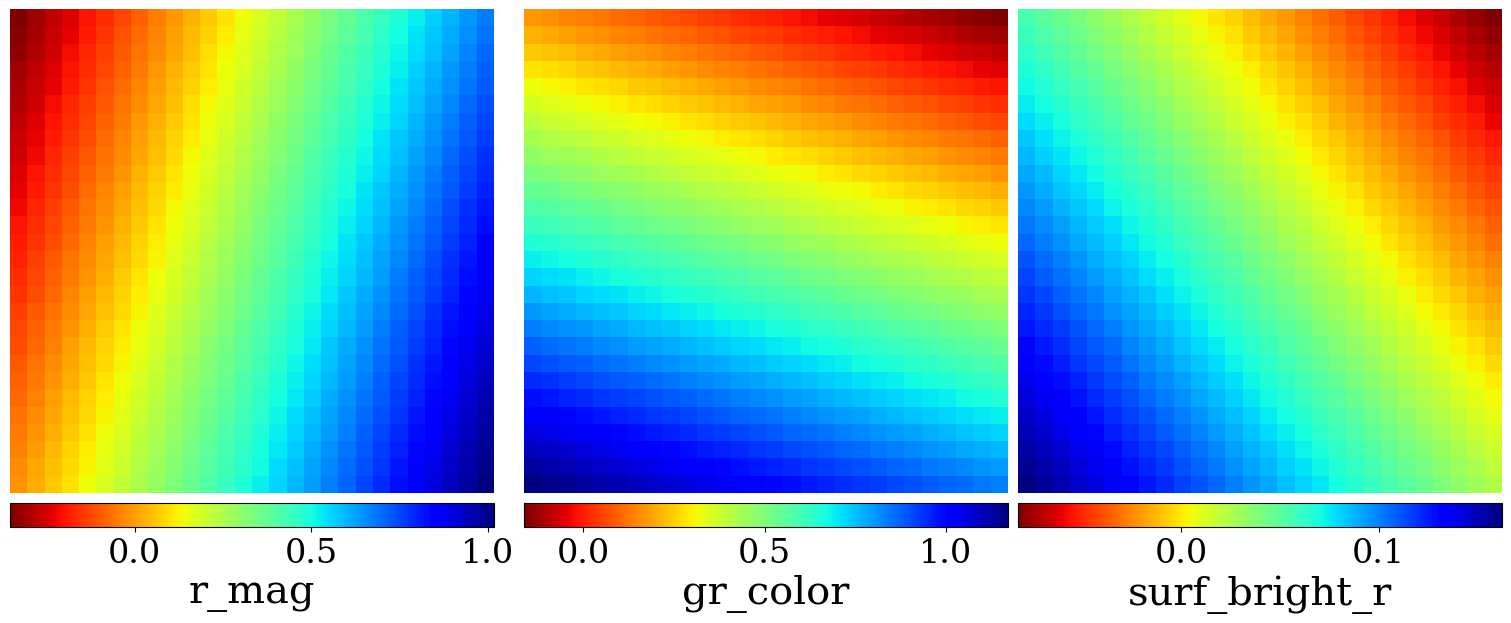

In [60]:
#Visualize SOM before training
SOM.show_map()

#Look at initial quantization error
from mpdg_som_utils import SOM_ErrorEstimators

initial_quant_error = SOM_ErrorEstimators.quantization_error(SOM.weights_map,
                                                             SOM.data,
                                                             SOM.bmu_indices)
print(f'| Initial quantization error: {initial_quant_error:.3f}')

In [61]:
#Train the som
SOM.train()

Step 1 complete. Error: 0.278
Step 2 complete. Error: 0.285
Step 3 complete. Error: 0.297
Step 4 complete. Error: 0.271
Step 5 complete. Error: 0.302
Step 6 complete. Error: 0.262
Step 7 complete. Error: 0.263
Step 8 complete. Error: 0.272


KeyboardInterrupt: 


| SOM. Step 8. Initialization: pca


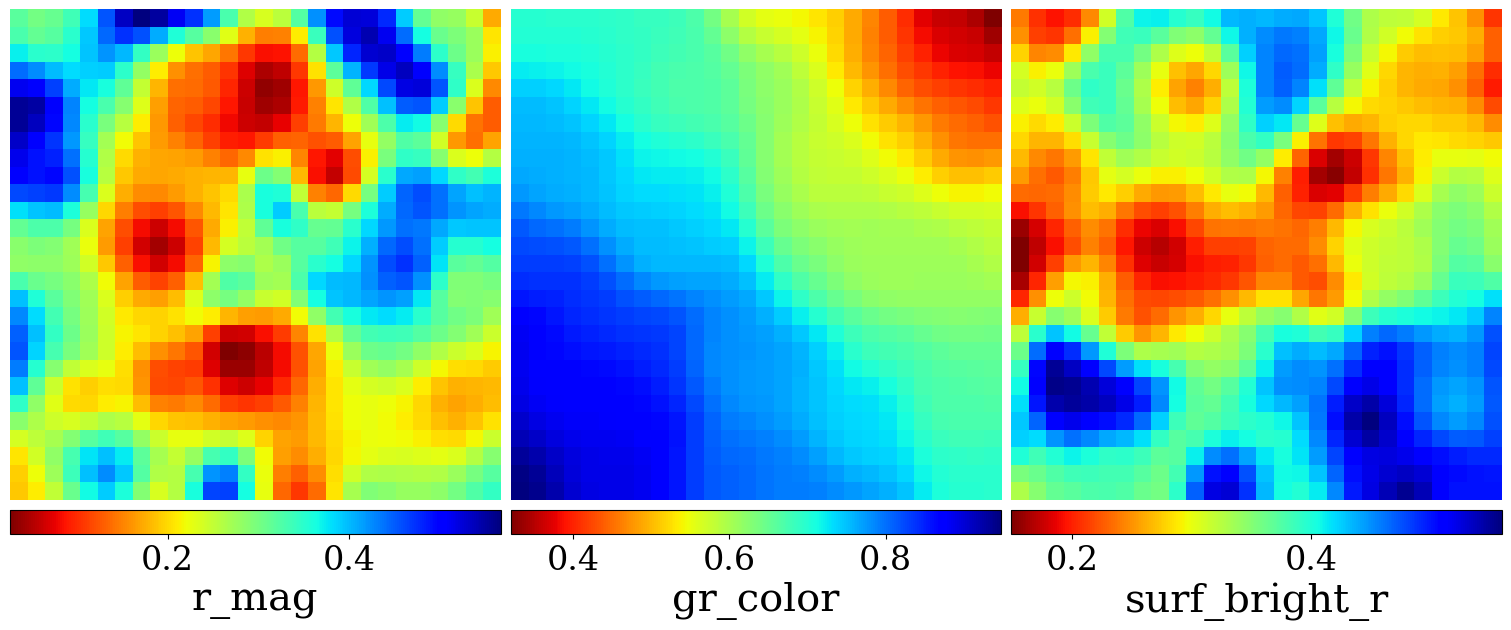

In [62]:
#Visualize the SOM after training
SOM.show_map()


| SOM. Step 8. Initialization: pca


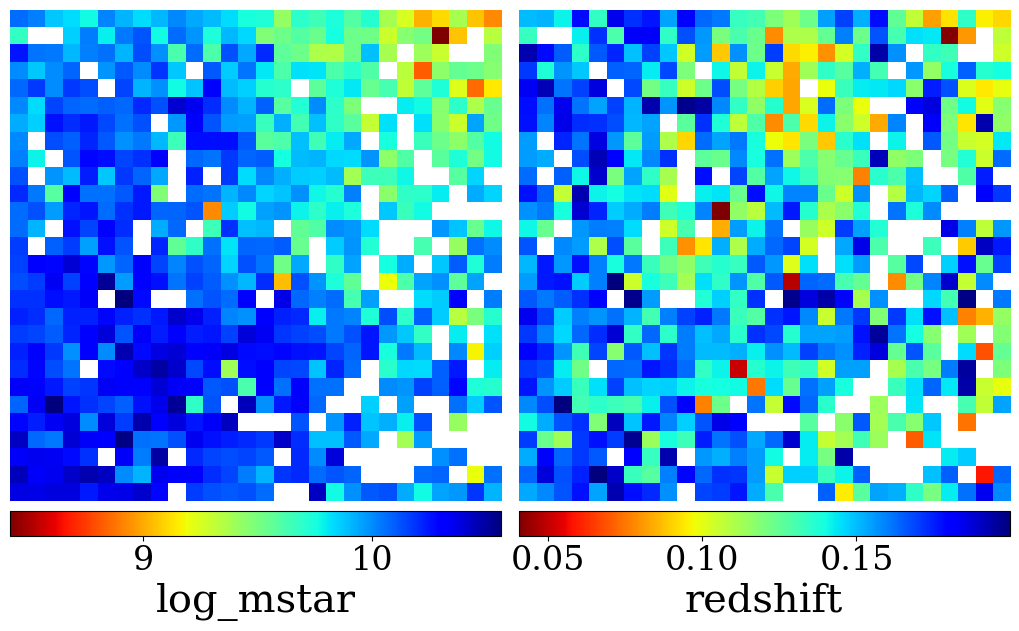

In [63]:
#Label the cells in the map with external parameters. Visualize the labeled map.
SOM.load_labeling_data(input_labels[:data_cut],
                       parameter_names = ['log_mstar', 'redshift'])
SOM.normalize_labeling_data()

SOM.label_map()

SOM.show_map(show_labeled = True)

In [71]:
#Find occupancy of cells:
cell_histogram = np.full(np.product(SOM.mapsize), np.nan)
for i, cell in enumerate(np.unique(SOM.bmu_indices, axis = 0)):
    cell_histogram[i] = np.sum(np.all(SOM.bmu_indices == cell, axis = -1))

print(f'The median occupancy of an occupied cell is: {np.nanmedian(cell_histogram)}')

The median occupancy of an occupied cell is: 8.0


In [74]:
from mpdg_som_utils import find_bmu_coords

In [75]:
labeled_map = np.full([*SOM.mapsize, SOM.labeling_data_dim - SOM.data_dim],
                            np.nan)

unitary_covar_vector = [1] * SOM.data_dim

labeling_data_bmu_idx = {}
for index in range(SOM.labeling_data_len):

    bmu_coords = find_bmu_coords(SOM.weights_map,
                                    SOM.labeling_data[index, :SOM.data_dim],
                                    unitary_covar_vector)
    
    if f'{bmu_coords}' in labeling_data_bmu_idx.keys():
        labeling_data_bmu_idx[f'{bmu_coords}'].append(index)
    else:
        labeling_data_bmu_idx[f'{bmu_coords}'] = []
        labeling_data_bmu_idx[f'{bmu_coords}'].append(index)

# self.labeled_map = np.full([*self.mapsize, self.labeling_data_dim - self.data_dim],
#                             np.nan)

# iteration_map = np.nditer(self.labeled_map[..., 0], flags = ['multi_index'])

# for _ in iteration_map:
    
#     index = iteration_map.multi_index

#     if f'{index}' in labeling_data_bmu_idx.keys():
#         local_vectors = self.labeling_data[labeling_data_bmu_idx[f'{index}']]
#         self.labeled_map[*index] = np.nanmedian(local_vectors[:, self.data_dim:], axis = 0)


In [76]:
labeling_data_bmu_idx

{'(3, 11)': [0, 201, 529, 609, 906, 5694],
 '(9, 1)': [1,
  171,
  202,
  376,
  570,
  1163,
  1749,
  3972,
  4215,
  4286,
  4510,
  4565,
  4613,
  5647,
  5651,
  5886,
  6051,
  6247,
  6838],
 '(23, 15)': [2,
  67,
  96,
  203,
  604,
  820,
  1567,
  1646,
  2082,
  2363,
  2366,
  2416,
  2564,
  3131,
  3253,
  3865,
  4287,
  4798,
  4799,
  4943,
  4962,
  5222,
  5223,
  5239,
  5533,
  5567,
  5626,
  5785,
  5846,
  6238,
  6740,
  7014,
  7018],
 '(10, 0)': [3,
  256,
  302,
  428,
  502,
  560,
  643,
  953,
  991,
  1063,
  1073,
  1086,
  1102,
  1108,
  1198,
  1253,
  1359,
  1487,
  1635,
  1882,
  1929,
  2125,
  2130,
  2358,
  2651,
  2895,
  2998,
  3248,
  3704,
  4298,
  4701,
  4955,
  5173,
  5302,
  5695,
  5726,
  6305,
  6690,
  6795,
  6813],
 '(27, 19)': [4,
  473,
  723,
  805,
  830,
  1915,
  2033,
  2152,
  2723,
  4320,
  4333,
  5575,
  6198,
  6786,
  7109],
 '(7, 14)': [5,
  31,
  86,
  164,
  204,
  250,
  378,
  407,
  460,
  518,
  573,
  8

In [97]:
delta_distribution = np.full(1000, 0)
delta_distribution[deltas_idx] = 1

In [93]:
mstar_values = SOM.labeling_data[labeling_data_bmu_idx['(3, 11)']][:, 3]

In [96]:
deltas_idx = [np.abs(distribution - mstar).argmin() for mstar in mstar_values]

In [91]:
distribution = np.linspace(np.min(SOM.labeling_data[:, 3]), np.max(SOM.labeling_data[:, 3]),
                           1000)

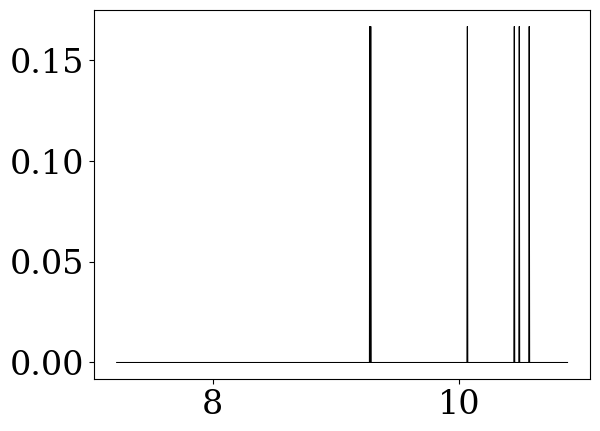

In [108]:
plt.plot(distribution,
         delta_distribution/np.sum(delta_distribution),
         color = 'black', linewidth = 0.75)

In [154]:
sigma = 0.45
gaussian_convolved = np.convolve(delta_distribution/np.sum(delta_distribution),
                                (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-distribution/(2 * sigma**2)),
                                mode = 'same')

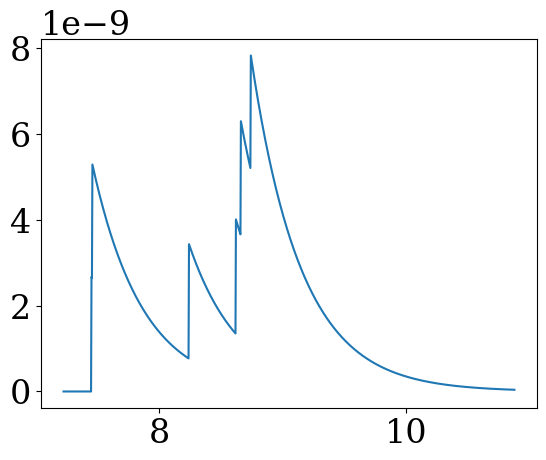

In [155]:
plt.plot(distribution,
         gaussian_convolved)

In [160]:
np.sum(gaussian_convolved/np.sum(gaussian_convolved) * distribution)

8.590990305617852

In [161]:
np.median(mstar_values)

10.257889

In [66]:
SOM.predict(SOM.data)

array([[ 9.59641933,  0.15219   ],
       [10.1392355 ,  0.16794001],
       [10.19797421,  0.1693    ],
       ...,
       [10.24870968,  0.13093501],
       [10.19793987,  0.17219   ],
       [ 9.95620823,  0.12873   ]])

___

Build distribution-in-cell function

___

Compare predictions to inputs

In [16]:
import matplotlib.pyplot as plt

<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_694013/2633600844.py:15: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
/var/tmp/lsajkov/ipykernel_694013/2633600844.py:16: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_694013/2633600844.py:20: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


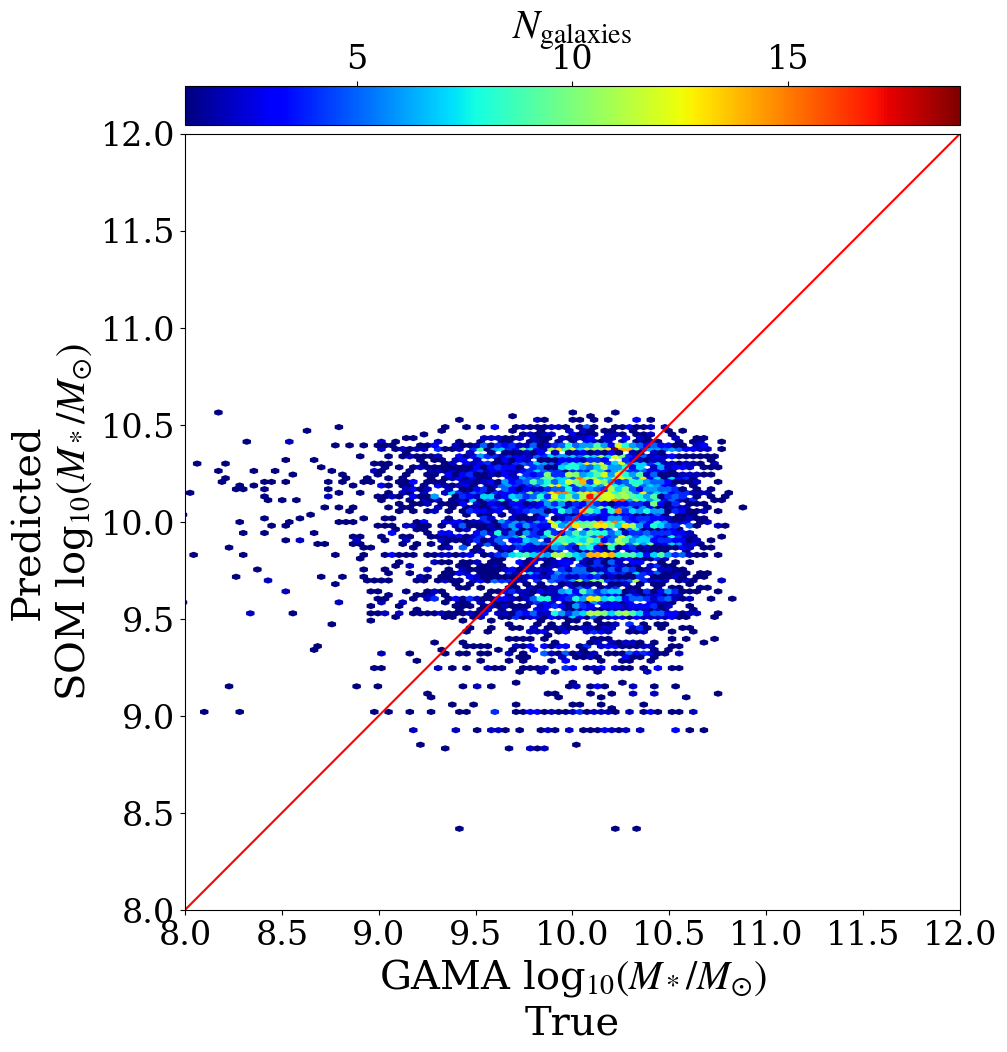

In [67]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim],
               SOM.prediction_results[:, 0],
               mincnt = 1, cmap = 'jet')

ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)
ax.set_xticks(np.arange(8, 12.5, 0.5))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_694013/3581022002.py:19: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


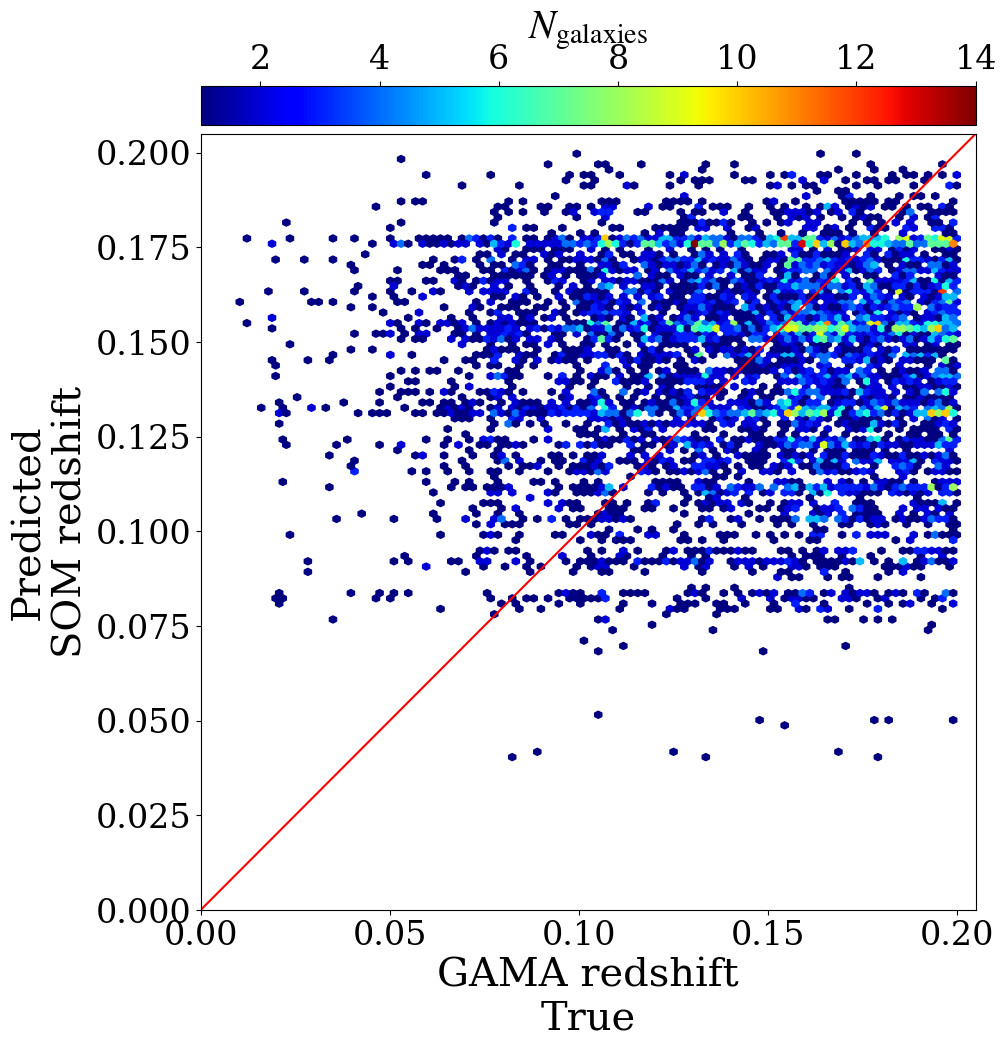

In [70]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim + 1],
               SOM.prediction_results[:, 1],
               mincnt = 1, cmap = 'jet')

ax.axline([0, 0], slope = 1, color = 'red')

ax.set_xlim(-0.0, 0.205)
ax.set_ylim(-0.0, 0.205)

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')